In [1]:
#! /usr/bin/env python
"""
Compute debris thickness through sub-debris and temperature inversion methods
"""
import sys
import os
import re
import subprocess
from datetime import datetime, timedelta
import time
import pickle
from collections import OrderedDict

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import median_absolute_deviation
import xarray as xr
from osgeo import gdal, ogr, osr

from pygeotools.lib import malib, warplib, geolib, iolib, timelib


import debrisglobal.globaldebris_input as debris_prms
from debrisglobal.glacfeat import GlacFeat, create_glacfeat
from meltcurves import melt_fromdebris_func
from meltcurves import debris_frommelt_func
from spc_split_lists import split_list


debug=True

In [2]:
#Function to generate a 3-panel plot for input arrays
def plot_array(dem, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None, close_fig=True):
    fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(10,5))
    alpha = 1.0
    #Gray background
    ax.set_facecolor('0.5')
    #Force aspect ratio to match images
    ax.set(aspect='equal')
    #Turn off axes labels/ticks
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if titles is not None:
        ax.set_title(titles[0])
    #Plot background shaded relief map
    if overlay is not None:
        alpha = 0.7
        ax.imshow(overlay, cmap='gray', clim=(1,255))
    #Plot each array
    im_list = [ax.imshow(dem, clim=clim, cmap=cmap, alpha=alpha)]
    fig.tight_layout()
    fig.colorbar(im_list[0], label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    if close_fig:
        plt.close(fig)
        

def maskedarray_gt(data, value):
    """ Greater than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data > value] = value
    return data


def maskedarray_lt(data, value):
    """ Less than operation on masked array to avoid warning errors """
    data = np.nan_to_num(data,0)
    data[data < value] = value
    return data


# def ts_fromdebris_func(h, a, b, c):
#         """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
#         Hill Equation"""
#         return a * h**c / (b**c + h**c)
# def debris_fromts_func(ts, a, b, c, ts_offset=0):
#     """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
#     Hill Equation"""
#     ts_woffset = ts + ts_offset
#     return (ts_woffset * b**c / (a - ts))**(1/c)


# def melt_fromts_func(ts, a, b, c, b0, k):
#     """ estimate melt from surface temperature 
#     Parameters
#     ----------
#     ts : surface temperature
#     a, b, c : coefficients with debris-ts curve (Hill equation)
#     b0, k: coefficients with debris-melt curve (2nd order reaction rate)
#     """
#     return b0 / (1 + k* b0 * (ts * b**c / (a - ts))**(1/c))



# def meltfactor_fromdebris_func(h, a, k, melt_2cm):
#     """ estimate melt factor from debris thickness (h is debris thickness, a and k are coefficients) 
#     Hill equation """
#     melt_h = a / (1 + 2 * k * a * h)
#     melt_factor = melt_h / melt_2cm
#     melt_factor[melt_factor > 1] = 1
#     return melt_factor



In [3]:
rgiid_list = []
rgiid_fn_list = []
for i in os.listdir(debris_prms.mb_binned_fp):
    if i.endswith('_mb_bins.csv'):
        region = int(i.split('.')[0])
        if region in debris_prms.roi_rgidict[debris_prms.roi]:    
            if region < 10:
                rgiid_list.append(i[0:7])
            else:
                rgiid_list.append(i[0:8])
            rgiid_fn_list.append(i)
        
        
rgiid_list = sorted(rgiid_list)
rgiid_fn_list = sorted(rgiid_fn_list)

rgiid_fn_list

print(len(rgiid_list))

# rgiid_list = ['01.25579'] # ERROR WITH NO CLEAN ICE
# rgiid_fn_list = ['01.25579_mb_bins.csv']
# rgiid_list = ['01.13622'] # ERROR WITH A PLOT - NEED TO TROUBLESHOOT
# rgiid_fn_list = ['01.13622_mb_bins.csv']
# rgiid_list = ['01.15645']
# rgiid_fn_list = ['01.15645_mb_bins.csv']

# rgiid_list = ['02.12438']
# rgiid_fn_list = ['02.12438_mb_bins.csv']

# rgiid_list = ['11.01604']
# rgiid_fn_list = ['11.01604_mb_bins.csv']
# rgiid_list = ['11.02810']
# rgiid_fn_list = ['11.02810_mb_bins.csv']
# rgiid_list = ['11.03005']
# rgiid_fn_list = ['11.03005_mb_bins.csv']
# rgiid_list = ['11.01604', '11.02810', '11.03005']
# rgiid_fn_list = ['11.01604_mb_bins.csv', '11.02810_mb_bins.csv', '11.03005_mb_bins.csv']

# rgiid_list = ['15.02240']
# rgiid_fn_list = ['15.02240_mb_bins.csv']

# rgiid_list = ['13.00809']
# rgiid_fn_list = ['13.00809_mb_bins.csv']
# rgiid_list = ['13.43232']
# rgiid_fn_list = ['13.43232_mb_bins.csv']
# rgiid_list = ['14.04477']
# rgiid_fn_list = ['14.04477_mb_bins.csv']
# rgiid_list = ['14.06794']
# rgiid_fn_list = ['14.06794_mb_bins.csv']
# rgiid_list = ['14.16042']
# rgiid_fn_list = ['14.16042_mb_bins.csv']
# rgiid_list = ['15.03357']
# rgiid_fn_list = ['15.03357_mb_bins.csv']
# rgiid_list = ['15.03473']
# rgiid_fn_list = ['15.03473_mb_bins.csv']
# rgiid_list = ['15.03743']
# rgiid_fn_list = ['15.03743_mb_bins.csv']
# rgiid_list = ['15.03733']
# rgiid_fn_list = ['15.03733_mb_bins.csv']
# rgiid_list = ['15.04121']
# rgiid_fn_list = ['15.04121_mb_bins.csv']
# rgiid_list = ['15.07886']
# rgiid_fn_list = ['15.07886_mb_bins.csv']
# rgiid_list = ['13.43232', '14.04477', '14.06794', '14.16042', '14.15447', '15.03473', '15.03733', '15.03734', 
#               '15.04121', '15.07886']
# rgiid_fn_list = ['13.43232_mb_bins.csv', '14.04477_mb_bins.csv', '14.06794_mb_bins.csv', '14.16042_mb_bins.csv', 
#                  '14.15447_mb_bins.csv', '15.03473_mb_bins.csv', '15.03733_mb_bins.csv', '15.03734_mb_bins.csv', 
#                  '15.04121_mb_bins.csv', '15.07886_mb_bins.csv']

# rgiid_list = ['17.13720']
# rgiid_fn_list = ['17.13720_mb_bins.csv']

# rgiid_list = ['18.02505']
# rgiid_fn_list = ['18.02505_mb_bins.csv']

# print('\nHACK!!!!\nDELETE ME-add glaciers back in!\n')

main_glac_rgi = debris_prms.selectglaciersrgitable(rgiid_list)
main_glac_rgi['CenLon_360'] = main_glac_rgi['CenLon']
main_glac_rgi.loc[main_glac_rgi['CenLon_360'] < 0, 'CenLon_360'] = (
    360 + main_glac_rgi.loc[main_glac_rgi['CenLon_360'] < 0, 'CenLon_360'])
main_glac_rgi['bin_fn'] = rgiid_fn_list

35
35 glaciers in region 18 are included in this model run: ['00631', '00661', '00686', '00707', '00716', '00718', '00815', '00853', '00891', '01018', '01130', '01852', '01889', '01958', '01959', '02210', '02230', '02257', '02270', '02276', '02298', '02342', '02436', '02450', '02472', '02499', '02502', '02504', '02505', '02508', '03066', '03156', '03167', '03181', '03191'] and more
This study is focusing on 35 glaciers in region [18]


In [4]:
# Latitude and longitude index to run the model
#  Longitude must be 0 - 360 degrees
latlon_all = []
for i in os.listdir(debris_prms.ostrem_fp):
    if i.endswith(debris_prms.ostrem_fn_sample.split('XXXX')[1]):
        latlon_fn = i.split(debris_prms.ostrem_fn_sample.split('XXXX')[1])[0]
        # Extract latitude
        lat_str = latlon_fn.split('-')[0]
        if 'N' in lat_str:
            i_lat = int(lat_str.split('N')[0]) / 100
        elif 'S' in lat_str:
            i_lat = -1 * int(lat_str.split('S')[0]) / 100
        # Extract longitude
        lon_str = latlon_fn.split('-')[1]
        i_lon = int(lon_str.split('E')[0]) / 100
        latlon_all.append([i_lat, i_lon, i])
latlon_all = sorted(latlon_all)

lat_all = np.array([x[0] for x in latlon_all])
lon_all = np.array([x[1] for x in latlon_all])
ostrem_fn_all_raw = [x[2] for x in latlon_all]

main_glac_rgi['lat_nearest'] = np.nan
main_glac_rgi['lon_nearest'] = np.nan
main_glac_rgi['ostrem_fn'] = np.nan
for nglac, glac_idx in enumerate(main_glac_rgi.index.values):
# for nglac, glac_idx in enumerate([main_glac_rgi.index.values[6855]]):

#     if verbose:
#         print(nglac, glac_idx, main_glac_rgi.loc[glac_idx,'rgino_str'], 
#               main_glac_rgi.loc[glac_idx,'CenLat'], main_glac_rgi.loc[glac_idx,'CenLon'])
        
    latlon_dist = (((main_glac_rgi.loc[glac_idx,'CenLat'] - lat_all)**2 + 
                    (main_glac_rgi.loc[glac_idx,'CenLon_360'] - lon_all)**2)**0.5)
    latlon_nearidx = np.where(latlon_dist == latlon_dist.min())[0][0]
    
    main_glac_rgi.loc[glac_idx,'lat_nearest'] = lat_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'lon_nearest'] = lon_all[latlon_nearidx]
    main_glac_rgi.loc[glac_idx,'ostrem_fn'] = ostrem_fn_all_raw[latlon_nearidx]
    
ostrem_fn_all = sorted(list(np.unique(main_glac_rgi['ostrem_fn'].values)))

# Merge with debris cover stats
dc_shp = gpd.read_file(debris_prms.debriscover_fp + debris_prms.debriscover_fn_dict[debris_prms.roi])
dc_shp = dc_shp.sort_values(by=['RGIId'])
dc_shp.reset_index(inplace=True, drop=True)

# main_glac_rgi['DC_Area_%'] = 0
dc_areaperc_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area__1'].values))
main_glac_rgi['DC_Area_%'] = main_glac_rgi.RGIId.map(dc_areaperc_dict).fillna(0)
dc_area_dict = dict(zip(dc_shp.RGIId.values,dc_shp['DC_Area_v2'].values))
main_glac_rgi['DC_Area_v2'] = main_glac_rgi.RGIId.map(dc_area_dict).fillna(0)
main_glac_rgi

,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,...,glacno,rgino_str,RGIId_float,CenLon_360,bin_fn,lat_nearest,lon_nearest,ostrem_fn,DC_Area_%,DC_Area_v2
GlacNo,,,,,,,,,,,,,,,,,,,,,
0,630,RGI60-18.00631,168.624,-44.5376,18,1,2.472,1465,2357,2050,...,631,18.00631,18.00631,168.624,18.00631_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.907,343770
1,660,RGI60-18.00661,168.556,-44.4630,18,1,7.027,1073,2553,1822,...,661,18.00661,18.00661,168.556,18.00661_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,22.975,1614468
2,685,RGI60-18.00686,168.609,-44.4545,18,1,9.656,1036,2522,1832,...,686,18.00686,18.00686,168.609,18.00686_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,14.807,1429743
3,706,RGI60-18.00707,168.578,-44.4393,18,1,5.191,1282,2514,1982,...,707,18.00707,18.00707,168.578,18.00707_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.327,691794
4,715,RGI60-18.00716,168.482,-44.4689,18,1,4.053,1292,2455,1985,...,716,18.00716,18.00716,168.482,18.00716_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.343,540795
5,717,RGI60-18.00718,168.495,-44.4852,18,1,2.311,1136,2432,1834,...,718,18.00718,18.00718,168.495,18.00718_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.935,322029
6,814,RGI60-18.00815,168.358,-44.5016,18,1,2.833,1186,2276,1597,...,815,18.00815,18.00815,168.358,18.00815_mb_bins.csv,-44.50,168.25,4450S-16825E-debris_melt_curve.nc,24.137,683812
7,852,RGI60-18.00853,168.363,-44.4743,18,1,10.960,809,2382,1827,...,853,18.00853,18.00853,168.363,18.00853_mb_bins.csv,-44.50,168.25,4450S-16825E-debris_melt_curve.nc,15.947,1747776
8,890,RGI60-18.00891,168.590,-44.3842,18,1,3.315,1425,2134,1805,...,891,18.00891,18.00891,168.590,18.00891_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,5.538,183580


In [5]:
# Add the original mass balance filenames for z_offset adjustments
mb_data_fullfn_dict = {}
# for mb_dataset in debris_prms.mb_datasets:
#     mb_binned_fp = debris_prms.mb_dataset_fp_dict[mb_dataset]    
for i in os.listdir(debris_prms.mb_binned_fp):
    if i.endswith('_mb_bins.csv'):
        rgiid_raw = i.split('_')[0]
        rgiid = 'RGI60-' + rgiid_raw.split('.')[0].zfill(2) + '.' + rgiid_raw.split('.')[1]
        mb_data_fullfn_dict[rgiid] = debris_prms.mb_binned_fp + i

main_glac_rgi['mb_data_fullfn'] = main_glac_rgi.RGIId.map(mb_data_fullfn_dict)
            
print('roi:', debris_prms.roi)
main_glac_rgi

roi: 18


,O1Index,RGIId,CenLon,CenLat,O1Region,O2Region,Area,Zmin,Zmax,Zmed,...,rgino_str,RGIId_float,CenLon_360,bin_fn,lat_nearest,lon_nearest,ostrem_fn,DC_Area_%,DC_Area_v2,mb_data_fullfn
GlacNo,,,,,,,,,,,,,,,,,,,,,
0,630,RGI60-18.00631,168.624,-44.5376,18,1,2.472,1465,2357,2050,...,18.00631,18.00631,168.624,18.00631_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.907,343770,/Users/davidrounce/Documents/Dave_Rounce/Debri...
1,660,RGI60-18.00661,168.556,-44.4630,18,1,7.027,1073,2553,1822,...,18.00661,18.00661,168.556,18.00661_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,22.975,1614468,/Users/davidrounce/Documents/Dave_Rounce/Debri...
2,685,RGI60-18.00686,168.609,-44.4545,18,1,9.656,1036,2522,1832,...,18.00686,18.00686,168.609,18.00686_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,14.807,1429743,/Users/davidrounce/Documents/Dave_Rounce/Debri...
3,706,RGI60-18.00707,168.578,-44.4393,18,1,5.191,1282,2514,1982,...,18.00707,18.00707,168.578,18.00707_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.327,691794,/Users/davidrounce/Documents/Dave_Rounce/Debri...
4,715,RGI60-18.00716,168.482,-44.4689,18,1,4.053,1292,2455,1985,...,18.00716,18.00716,168.482,18.00716_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.343,540795,/Users/davidrounce/Documents/Dave_Rounce/Debri...
5,717,RGI60-18.00718,168.495,-44.4852,18,1,2.311,1136,2432,1834,...,18.00718,18.00718,168.495,18.00718_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,13.935,322029,/Users/davidrounce/Documents/Dave_Rounce/Debri...
6,814,RGI60-18.00815,168.358,-44.5016,18,1,2.833,1186,2276,1597,...,18.00815,18.00815,168.358,18.00815_mb_bins.csv,-44.50,168.25,4450S-16825E-debris_melt_curve.nc,24.137,683812,/Users/davidrounce/Documents/Dave_Rounce/Debri...
7,852,RGI60-18.00853,168.363,-44.4743,18,1,10.960,809,2382,1827,...,18.00853,18.00853,168.363,18.00853_mb_bins.csv,-44.50,168.25,4450S-16825E-debris_melt_curve.nc,15.947,1747776,/Users/davidrounce/Documents/Dave_Rounce/Debri...
8,890,RGI60-18.00891,168.590,-44.3842,18,1,3.315,1425,2134,1805,...,18.00891,18.00891,168.590,18.00891_mb_bins.csv,-44.50,168.50,4450S-16850E-debris_melt_curve.nc,5.538,183580,/Users/davidrounce/Documents/Dave_Rounce/Debri...




     SWITCH BACK!


1 of 10 :
   4325S-17075E-debris_melt_curve.nc
   4325S-17075E-debris_ts_curve.nc


     SWITCH BACK!


   18.03066
bin_idx_term pre-jump: [ 5  6  7 10 12 13 14 15 16 17 18]
bin_idx_term: [5 6 7]
0 0.7882804976386037
1 0.5421982302662851
2 0.3691709185958741
3 0.7882805088030304
4 0.7882804976386037
5 0.7882804697275373
6 0.7676005738886862
7 0.7879744281266597
8 0.6997328422691609
9 0.7813195190162064
10 0.6632816003144744
11 0.7784427505564512
12 0.7882804753097505
13 0.733933537753354
14 0.7882805088030304
15 0.7882804976386037
16 0.7882804697275373
17 0.7482166740378592
18 0.44595498840278364
19 0.7475657484974977
20 0.5710908374463464
21 0.7183211306749459
22 0.7882805088030304
23 0.73737006898727
24 0.7375542612564542
25 0.29133743349298286
26 0.5616660712079828
27 0.17711599047508522
28 0.15552886786680323
29 0.1935953785733209
30 0.016877683811947118
31 0.09989685947870311
32 0.4698096204181859
33 0.5638296080857432
34 0.23701937270620602
35 0.788280508803

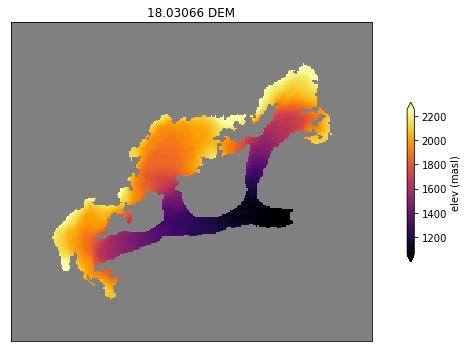

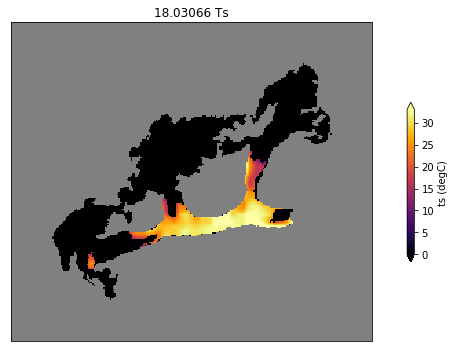

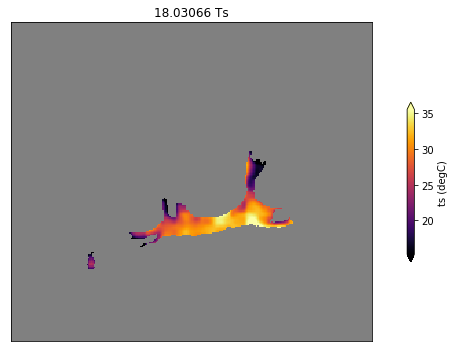

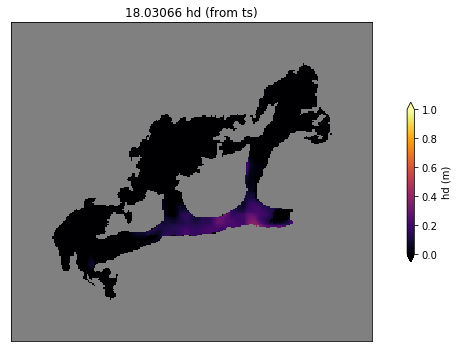

In [6]:
# ===== ESTIMATE DEBRIS THICKNESS FOR ALL GLACIERS WITH OBSERVATIONS =====
add_debris2bins = True
plot_tscurve = True
plot_ostrem = True
# plot_ostrem_norm = True
add_meltfactor = True
overwrite_hd = True

def ts_fromdebris_func(h, a, b, c):
    """ estimate surface temperature from debris thickness (h is debris thickness, a and k are coefficients) 
        Hill Equation"""
    return a * h**c / (b**c + h**c)

if add_debris2bins:
    
    dhdt_vel_fns_fn = debris_prms.dhdt_vel_fns_fn.replace('XXXX',debris_prms.roi)
    dhdt_vel_fns_df = pd.read_csv(debris_prms.dhdt_vel_fns_fp + dhdt_vel_fns_fn)
    
    ts_fns_df = pd.read_csv(debris_prms.ts_fp + debris_prms.ts_fns_fn)
    
    for nostrem, ostrem_fn in enumerate(ostrem_fn_all):
#     for nostrem, ostrem_fn in enumerate([ostrem_fn_all[0]]):

        print(nostrem+1, 'of', len(ostrem_fn_all), ':\n  ', ostrem_fn)

        # ===== LOAD DAILY MELT DATA (OSTREM DATA) =====
        nelev = 0
        ds_ostrem = xr.open_dataset(debris_prms.ostrem_fp + ostrem_fn)
        
        # ===== LOAD SURFACE TEMPERATURE DATA (TS INVERSION DATA) - STATS OVER MELT SEASON AROUND ACQUISITION TIME =====
        tscurve_fn = debris_prms.output_ts_fn_sample.replace('XXXX', ostrem_fn.split('-debris')[0] + '-')
        
        print('  ', tscurve_fn)
        
        if os.path.exists(debris_prms.tscurve_fp + tscurve_fn):
            
            ds_ts = xr.open_dataset(debris_prms.tscurve_fp + tscurve_fn)
            debris_thicknesses = ds_ts.hd_cm.values / 100
            
            dsnow_data = ds_ts['dsnow'][:,:,nelev].values.sum(axis=0)
            nosnow_cols = np.where(dsnow_data == 0)[0]
            ts_data = ds_ts['ts'][:,nosnow_cols,nelev].values
            # replace clean-ice values
            ts_data[ts_data == 0] = 273.15
            # convert to degC
            ts_data = ts_data - 273.15

            ts_coeff_daily_cns = ['a', 'b', 'c', 'dif']
            ts_coeff_daily = pd.DataFrame(np.zeros((ts_data.shape[1],len(ts_coeff_daily_cns))), 
                                          columns=ts_coeff_daily_cns)
            
            plot_ts_alldays = False
            if plot_ts_alldays:
                fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, 
                                       gridspec_kw = {'wspace':0.4, 'hspace':0.15})
    
            for ncol in np.arange(ts_data.shape[1]):
                ts_day = ts_data[:,ncol]
                # Fit function
                func_coeff_ts, pcov = curve_fit(ts_fromdebris_func, 
                                                debris_thicknesses, ts_day,
                                                p0=[25,1,0.45],
#                                                 bounds=((0,0,0.01),(100,4,1)),
                                                bounds=((0,0.1,0.2),(100,20,0.5)),
                                                )
                ts_coeff_daily.loc[ncol,'a'] = func_coeff_ts[0]
                ts_coeff_daily.loc[ncol,'b'] = func_coeff_ts[1]
                ts_coeff_daily.loc[ncol,'c'] = func_coeff_ts[2]
                
                if plot_ts_alldays:
                    debris_4curve = np.arange(0.,debris_prms.hd_max+0.01,0.01)
                    ts_day_mod = ts_fromdebris_func(debris_thicknesses, func_coeff_ts[0], func_coeff_ts[1], 
                                                    func_coeff_ts[2])
                    ax[0,0].plot(debris_thicknesses, ts_day_mod)
                
        # Select all glaciers that share the same Ostrem curve
        main_glac_rgi_subset = main_glac_rgi.loc[np.where(main_glac_rgi['ostrem_fn'] == ostrem_fn)[0],:]
        main_glac_rgi_subset.reset_index(inplace=True, drop=True)    

        for nglac, glac_idx in enumerate(main_glac_rgi_subset.index.values):
#         for nglac, glac_idx in enumerate([main_glac_rgi_subset.index.values[0]]):
            glac_str = main_glac_rgi_subset.loc[glac_idx,'rgino_str']
            rgiid = main_glac_rgi_subset.loc[glac_idx,'RGIId']
            region = glac_str.split('.')[0]
            if int(glac_str.split('.')[0]) < 10:
                glac_str = glac_str[1:]
                
            # dhdt and velocity filenames
            fn_idx = np.where(dhdt_vel_fns_df['RGIId'].values == rgiid)[0][0]
            dhdt_fn_wglacier = dhdt_vel_fns_df.loc[fn_idx,'dhdt_fullfn']
            vx_fn_wglacier = dhdt_vel_fns_df.loc[fn_idx,'vel_fullfn']
            
            # Ts filename
            ts_fn_idx = np.where(ts_fns_df['RGIId'].values == rgiid)[0][0]
            ts_fn = ts_fns_df.loc[ts_fn_idx,'ts_fullfn']
                
            if int(region) < 10:
                glac_str_noleadzero = str(int(glac_str.split('.')[0])) + '.' + glac_str.split('.')[1]
            else:
                glac_str_noleadzero = glac_str
                
            print('  ', glac_str)
                  
            if ((not os.path.exists(debris_prms.hd_fp + debris_prms.hd_fn_sample.replace('XXXX',glac_str_noleadzero)) 
                and ((main_glac_rgi_subset.loc[glac_idx, 'DC_Area_%'] > debris_prms.dc_percarea_threshold) | 
                     (main_glac_rgi_subset.loc[glac_idx, 'DC_Area_v2'] / 1e6 > debris_prms.dc_area_threshold)) 
               and (ts_fn not in ['0.0'])) | overwrite_hd):
                
                mb_fn = glac_str + '_mb_bins.csv'
                mb_df = pd.read_csv(debris_prms.mb_binned_fp + mb_fn)
                mb_df.loc[:,:] = mb_df.values.astype(np.float64)
                
                # Optimized parameters
                hdopt_cns = ['glac_str', 'melt_mwea_clean', 'melt_mwea_2cm', 'b0', 'k', 'a', 'b', 'c']
                df_hdopt_prms = pd.DataFrame(np.zeros((len(debris_prms.elev_cns),len(hdopt_cns))), columns=hdopt_cns)
                df_hdopt_prms['glac_str'] = glac_str
                
                # ===== Ostrem Curve =====
                start_yearfrac = debris_prms.mb_yrfrac_dict[debris_prms.roi][0] 
                end_yearfrac = debris_prms.mb_yrfrac_dict[debris_prms.roi][1] 
                time_year = pd.to_datetime(ds_ostrem.time.values).year
                time_daysperyear = np.array([366 if x%4 == 0 else 365 for x in time_year])
                time_yearfrac = time_year + (pd.to_datetime(ds_ostrem.time.values).dayofyear-1) / time_daysperyear

                start_idx = np.where(abs(time_yearfrac - start_yearfrac) == abs(time_yearfrac - start_yearfrac).min())[0][0]
                end_idx = np.where(abs(time_yearfrac - end_yearfrac) == abs(time_yearfrac - end_yearfrac).min())[0][0]

                # Debris thickness
                debris_thicknesses = ds_ostrem.hd_cm.values / 100
                debris_melt_df = pd.DataFrame(np.zeros((len(debris_thicknesses),2)), 
                                              columns=['debris_thickness', 'melt_mwea'])  

                for nelev, elev_cn in enumerate(debris_prms.elev_cns):

                    for ndebris, debris_thickness in enumerate(debris_thicknesses):                    
                        melt_mwea = (ds_ostrem['melt'][ndebris,start_idx:end_idx,nelev].values.sum() / 
                                    (len(time_yearfrac[start_idx:end_idx])/365.25))
                        debris_melt_df.loc[ndebris] = debris_thickness, melt_mwea
                    
                    # Fit curve
                    fit_idx = list(np.where(debris_thicknesses >= 0.05)[0])            
                    func_coeff, pcov = curve_fit(melt_fromdebris_func, 
                                                 debris_melt_df.debris_thickness.values[fit_idx], 
                                                 debris_melt_df.melt_mwea.values[fit_idx])
                    melt_cleanice = debris_melt_df.loc[0,'melt_mwea']
                    idx_2cm = np.where(debris_thicknesses == 0.02)[0][0]
                    melt_2cm = debris_melt_df.loc[idx_2cm, 'melt_mwea']
                    melt_thickest = melt_fromdebris_func(debris_melt_df.debris_thickness.max(), func_coeff[0], func_coeff[1])

                    if melt_cleanice == 0:
                        troubleshoot_fp = debris_prms.output_fp + 'errors/' + debris_prms.roi + '/'
                        if not os.path.exists(troubleshoot_fp):
                            os.makedirs(troubleshoot_fp)
                        with open(troubleshoot_fp + glac_str + "-no_cleanice_melt.txt", "w") as text_file:
                            text_file.write(glac_str + ' clean ice melt is zero; causes issues for melt factors')
                    
                    # Add optimized parameters
                    df_hdopt_prms.loc[nelev,'melt_mwea_clean'] = melt_cleanice
                    df_hdopt_prms.loc[nelev,'melt_mwea_2cm'] = melt_2cm
                    df_hdopt_prms.loc[nelev,'b0'] = func_coeff[0]
                    df_hdopt_prms.loc[nelev,'k'] = func_coeff[1]

                    # ===== PLOT DEBRIS VS. SURFACE LOWERING ===== 
                    if plot_ostrem and nelev == 0:
                        fig, ax = plt.subplots(1, 2, squeeze=False, sharex=True, sharey=False, 
                                              gridspec_kw = {'wspace':0.3, 'hspace':0.15})
                        # Fitted curves
                        debris_4curve = np.arange(0.02,debris_prms.hd_max+0.01,0.01)
                        melt_4curve = melt_fromdebris_func(debris_4curve, func_coeff[0], func_coeff[1])
                        melt_4curve[melt_4curve > melt_2cm] = melt_2cm
                        melt_4curve_norm = melt_4curve / melt_cleanice
                        # ===== MELT =====
                        ax[0,0].plot(debris_melt_df['debris_thickness'], debris_melt_df['melt_mwea'], 'o', 
                                     color='k', markersize=3, markerfacecolor="None", markeredgewidth=0.75, zorder=3)
                        ax[0,0].plot(debris_4curve, melt_4curve, 
                                     color='k', linewidth=1, linestyle='--', zorder=4)
                        # text
                        ax[0,0].text(0.5, 1.05, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
                                     transform=ax[0,0].transAxes)
                        eqn_text = r'$b = \frac{b_{0}}{1 + kb_{0}h}$'
                        coeff1_text = r'$b_{0} = ' + str(np.round(func_coeff[0],2)) + '$' 
                        coeff2_text = r'$k = ' + str(np.round(func_coeff[1],2)) + '$' 
                        # coeff$\frac{b_{0}}{1 + 2kb_{0}h}$'
                        ax[0,0].text(0.9, 0.95, eqn_text, size=12, horizontalalignment='right', verticalalignment='top', 
                                     transform=ax[0,0].transAxes)
                        ax[0,0].text(0.615, 0.83, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
                                     transform=ax[0,0].transAxes)
                        ax[0,0].text(0.66, 0.77, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                     transform=ax[0,0].transAxes)
                        ax[0,0].text(0.66, 0.7, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                     transform=ax[0,0].transAxes)
                        # X-label
                        ax[0,0].set_xlabel('Debris thickness(m)', size=12)
                        ax[0,0].set_xlim(0, 2.1)
                        #ax[0,0].set_xlim(0, debris_melt_df.debris_thickness.max())
                        ax[0,0].xaxis.set_tick_params(labelsize=12)
                        ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
                        ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
                        # Y-label
                        ax[0,0].set_ylabel('Melt (mwea)', size=12)
                        ax[0,0].set_ylim(0,(int(debris_melt_df.melt_mwea.values.max()/0.1)+3)*0.1)
                        ax[0,0].yaxis.set_major_locator(plt.MultipleLocator(1))
                        ax[0,0].yaxis.set_minor_locator(plt.MultipleLocator(0.1))
                        # Tick parameters
                        ax[0,0].yaxis.set_ticks_position('both')
                        ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
                        ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in') 
                        # ===== MELT FACTOR =====
                        ax[0,1].plot(debris_melt_df['debris_thickness'], 
                                     debris_melt_df['melt_mwea'] / melt_cleanice, 'o', 
                                     color='k', markersize=3, markerfacecolor="None", markeredgewidth=0.75, zorder=3)
                        ax[0,1].plot(debris_4curve, melt_4curve_norm, 
                                     color='k', linewidth=1, linestyle='--', zorder=4)
                        ax[0,1].plot(np.array([0,0.02]), np.array([1, melt_2cm/melt_cleanice]), 
                                     color='k', linewidth=1, linestyle='--', zorder=4)
                        # text
                        ax[0,1].text(0.5, 1.05, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
                                     transform=ax[0,1].transAxes)
#                         meltclean_text = r'$b_{clean} = ' + str(np.round(melt_cleanice,2)) + '$' 
#                         ax[0,1].text(0.66, 0.95, meltclean_text, size=10, horizontalalignment='left', verticalalignment='top', 
#                                      transform=ax[0,1].transAxes)
                        # Y-label
                        ax[0,1].set_ylabel('Melt factor (-)', size=12)
                        ax[0,1].set_ylim(0,(int(melt_4curve_norm.max()/0.1)+3)*0.1)
                        ax[0,1].yaxis.set_major_locator(plt.MultipleLocator(0.2))
                        ax[0,1].yaxis.set_minor_locator(plt.MultipleLocator(0.05))
                        # Tick parameters
                        ax[0,1].yaxis.set_ticks_position('both')
                        ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
                        ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in') 
    
                        fig.set_size_inches(8, 4)
                        figure_fn = glac_str + '_curve_hd_melt.png'
                        ostrem_fig_fp = debris_prms.output_fig_fp + debris_prms.roi + '/'
                        if not os.path.exists(ostrem_fig_fp):
                            os.makedirs(ostrem_fig_fp)
                        fig.savefig(ostrem_fig_fp + figure_fn, bbox_inches='tight', dpi=300)
                        plt.close()
                    
                    # Create glacier feature from ice thickness raster
                    thick_dir = debris_prms.oggm_fp + 'thickness/RGI60-' + str(region.zfill(2)) + '/'
                    thick_fn = 'RGI60-' + str(region.zfill(2)) + '.' + rgiid.split('.')[1] + '_thickness.tif'
                    gf = create_glacfeat(thick_dir, thick_fn)

                    # Debris shape layer processing
                    dc_shp_proj_fn = (debris_prms.glac_shp_proj_fp + glac_str + '_dc_crs' + 
                                      str(gf.aea_srs.GetAttrValue("AUTHORITY", 1)) + '.shp')
                    if not os.path.exists(dc_shp_proj_fn):
                        dc_shp_init = gpd.read_file(debris_prms.debriscover_fp + 
                                                    debris_prms.debriscover_fn_dict[debris_prms.roi])
                        dc_shp_single = dc_shp_init[dc_shp_init['RGIId'] == rgiid]
                        dc_shp_single = dc_shp_single.reset_index()
                        dc_shp_proj = dc_shp_single.to_crs({'init': 'epsg:' + 
                                                            str(gf.aea_srs.GetAttrValue("AUTHORITY", 1))})
                        dc_shp_proj.to_file(dc_shp_proj_fn)
                    dc_shp_ds = ogr.Open(dc_shp_proj_fn, 0)
                    dc_shp_lyr = dc_shp_ds.GetLayer()

                    # Add layers
                    gf.add_layers(dc_shp_lyr, gf_add_dhdt=True, dhdt_fn=dhdt_fn_wglacier, gf_add_vel=True, 
                                  vx_fn=vx_fn_wglacier, gf_add_ts=True, ts_fn=ts_fn, gf_add_slope_aspect=False)

                    # ===== PLOTS =====
                    if debug:
                        # DEM
                        var_full2plot = gf.z1.copy()
                        clim = malib.calcperc(var_full2plot, (2,98))
                        plot_array(var_full2plot, clim, [glac_str + ' DEM'], 'inferno', 'elev (masl)', close_fig=False)
                        # Surface temperature
                        var_full2plot = gf.ts.copy()
                        clim = malib.calcperc(var_full2plot, (2,98))
                        plot_array(var_full2plot, clim, [glac_str + ' Ts'], 'inferno', 'ts (degC)', close_fig=False)
                        # Surface temperature (debris-covered)
                        var_full2plot = gf.ts.copy()
                        var_full2plot.mask = gf.dc_mask
                        clim = malib.calcperc(var_full2plot, (2,98))
                        plot_array(var_full2plot, clim, [glac_str + ' Ts'], 'inferno', 'ts (degC)', close_fig=False)

                    # Bin data
                    outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size)
                    
                    # add emergence velocity from the mb_df
                    outbins_df['emvel_mean'] = mb_df['emvel_mean']
                    outbins_df['emvel_std'] = mb_df['emvel_std']
                    outbins_df['emvel_med'] = mb_df['emvel_med']
                    outbins_df['emvel_mad'] = mb_df['emvel_mad']
                    # uncertainty with flux divergence from Farinotti et al. (2019)
                    outbins_df['emvel_high'] = outbins_df['emvel_mean'] * 1.6
                    outbins_df['emvel_low'] = outbins_df['emvel_mean'] * 0.8
                    # modify mass balance based on emergence velocity
                    outbins_df['dc_mb_wem'] = outbins_df['dc_mb_bin_mean_mwea'] - outbins_df['emvel_mean']
                    # Higher emergence --> more melt
                    outbins_df['dc_mb_wemthick'] = outbins_df['dc_mb_bin_mean_mwea'] - outbins_df['emvel_high'] - outbins_df['dc_mb_bin_std_mwea']
                    # Lower emergence --> less melt
                    outbins_df['dc_mb_wemthin'] = outbins_df['dc_mb_bin_mean_mwea'] - outbins_df['emvel_low'] + outbins_df['dc_mb_bin_std_mwea']
                    
                    # add width to bins
                    widths_fp = debris_prms.oggm_fp + 'widths/' + 'RGI60-' + rgiid.split('-')[1].split('.')[0] + '/'
                    widths_fn = rgiid + '_widths_m.csv'
                    try:
                        # Add width to each elevation bin
                        widths_df = pd.read_csv(widths_fp + widths_fn)
                        elev_nearidx = (np.abs(outbins_df['bin_center_elev_m'].values[:,np.newaxis] - 
                                               widths_df['elev'].values).argmin(axis=1))
                        outbins_df['width_m'] = widths_df.loc[elev_nearidx,'width_m'].values
                    except:
                        outbins_df['width_m'] = 0
                    
                    # ===== OPTIMIZE STRICTLY BASED ON THE BINS (computationally efficient!) =====
                    # Column name to run objective on
                    ts_zscore = 0
                    mb_cn = 'dc_mb_wem'
                    ts_cn = 'dc_ts_mean'
                    
                    # Subset "terminus" bins based on the following:
                    #  - below velocity threshold (low emergence velocity)
                    #  - minimum debris-covered area (percentage and pixels)
                    #  - mass balance within range of sub-debris melt
                    #  - terminus of glacier 
                    bin_idx_term = np.where((outbins_df['vm_med'] <= debris_prms.vel_threshold)
                                            & (outbins_df['width_m'] >= debris_prms.width_min_dict[debris_prms.roi])
                                            & (outbins_df['dc_bin_area_perc'] >= debris_prms.debrisperc_threshold)
                                            & (outbins_df['dc_bin_count_valid'] >= 10)
                                            & (outbins_df[mb_cn] >= -1*melt_2cm)
                                            & (outbins_df[mb_cn] <= -1*melt_thickest)
                                            & (outbins_df['z1_bin_areas_perc_cum'] <= debris_prms.term_area_perc)
                                          )[0]
                    
                    
                    
                    if len(bin_idx_term) > 0:
                        
                        # Max number of bins
                        if len(bin_idx_term) > 20:
                            bin_idx_term = bin_idx_term[0:20]
                        
                        # Terminus only (no jumps)
                        if debug:
                            print('bin_idx_term pre-jump:', bin_idx_term)
                        bin_idx_dif = list(bin_idx_term[1:] - bin_idx_term[:-1])
                        if not(np.sum(bin_idx_dif) == len(bin_idx_term)-1):
                            idx_jumpinbins = bin_idx_dif.index(next(filter(lambda x: x>1, bin_idx_dif)))
                            bin_idx_term = bin_idx_term[0:idx_jumpinbins+1]
                        if debug:
                            print('bin_idx_term:', bin_idx_term)

                        # Thin debris based on coldest bin with significant debris cover
                        try:
                            bin_idx_thin = outbins_df.loc[np.where(outbins_df['dc_bin_count_valid'] >= 10)[0],'dc_ts_mean'].idxmin()
                        except:
                            bin_idx_thin = outbins_df.loc[np.where((outbins_df['dc_bin_area_perc_cum'] >= 95) & 
                                                                   (outbins_df['dc_bin_count_valid'] > 0))[0],'dc_ts_mean'].idxmin()
                        # set melt equal to 2 cm
                        outbins_df.loc[bin_idx_thin, mb_cn] = -1*melt_2cm
                        # concatenate terminus and thin bins
                        if bin_idx_thin not in bin_idx_term:
                            bin_idx_all = np.concatenate((bin_idx_term, np.array([bin_idx_thin])))
                        else:
                            bin_idx_all = bin_idx_term
                        
                        def debris_fromts_func(ts, a, b, c, hd_max=debris_prms.hd_max):
                            """ estimate debris thickness from surface temperature (ts is surface temperature, a and k are coefficients) 
                                Hill Equation"""
                            # If temperature exceeds maximum of function cause NaN value
                            max_value = ts_fromdebris_func(50, a, b, c)
                            if ts.size == 1:
                                if ts > max_value:
                                    ts = max_value
                                if ts < 0:
                                    ts = 0
                            else:
                                ts[ts > a] = max_value
                                ts[ts < 0] = 0
                            # Debris thickness
                            hd = (ts * b**c / (a - ts))**(1/c)
                            if ts.size == 1:
                                if hd > hd_max:
                                    hd = hd_max
                            else:
                                hd[hd > hd_max] = hd_max    
                            return hd
    
                        def melt_fromts_func(ts, a, b, c, b0, k, hd_max=debris_prms.hd_max, melt_2cm=melt_2cm):
                            """ estimate melt from surface temperature 
                            Parameters
                            ----------
                            ts : surface temperature
                            a, b, c : coefficients with debris-ts curve (Hill equation)
                            b0, k: coefficients with debris-melt curve (2nd order reaction rate)
                            """
                            ts_copy = ts.copy()
                            ts_max = ts_fromdebris_func(hd_max, a, b, c)
                            ts_copy[ts_copy > ts_max] = ts_max
                            hd = debris_fromts_func(ts_copy, a, b, c)
                            hd[hd < 0] = 0.02
                            hd[hd > hd_max] = hd_max
                            melt = melt_fromdebris_func(hd, b0, k)
                            melt[melt > melt_2cm] = melt_2cm
                            return melt
    
#                         def process_df_debris_subset(outbins_df, func_coeff_ts):
                        def process_df_debris_subset(func_coeff_ts):
                            # Estimate mass balance from surface temperature
                            outbins_df['mb_fromts'] = -1 * melt_fromts_func(
                                outbins_df[ts_cn], 
                                func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2], 
                                func_coeff[0], func_coeff[1])
                            # Compute difference
                            outbins_df['mb_fromts_dif'] = outbins_df['mb_fromts'] - outbins_df[mb_cn]
                            # Weighted difference
                            melt_dif_weighted_sum = (outbins_df.loc[bin_idx_all, 'mb_fromts_dif'] * 
                                                     outbins_df.loc[bin_idx_all, 'dc_bin_area_valid_km2']).sum()
                            melt_dif_weighted_sum_abs = abs(melt_dif_weighted_sum)
                            return outbins_df, melt_dif_weighted_sum, melt_dif_weighted_sum_abs
    
                        for nrow, func_coeff_ts in enumerate(ts_coeff_daily.values.tolist()):
                            outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
#                                 process_df_debris_subset(outbins_df, func_coeff_ts))
                                process_df_debris_subset(func_coeff_ts))
                            # record difference
                            ts_coeff_daily.loc[nrow,'dif'] = melt_dif_weighted_sum
                            if debug:
                                print(nrow, melt_dif_weighted_sum)
                        
                        # Best fit
                        ts_bestday_idx = np.where(abs(ts_coeff_daily.dif.values) == 
                                                  abs(ts_coeff_daily.dif.values).min())[0]
                        func_coeff_ts = ts_coeff_daily.loc[ts_bestday_idx,:].values[0][0:3]
                        outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
#                                 process_df_debris_subset(outbins_df, func_coeff_ts))
                                process_df_debris_subset(func_coeff_ts))
                        outbins_df[ts_cn] = outbins_df[ts_cn].fillna(value=0)
                        outbins_df['hd_ts'] = debris_fromts_func(outbins_df[ts_cn].values, func_coeff_ts[0], 
                                                                 func_coeff_ts[1], func_coeff_ts[2])
                        
                        # ===== TS OFFSET =====
                        def objective(ts_offset):
                            """
                            Objective function to fit ts_zscore for Ts inversions to the subdebris melt inversions

                            Parameters
                            ----------
                            ts_zscore : np.float64
                                temperature zscore used to shift data/curve up or down

                            Returns
                            -------
                            melt_dif_weighted_sum_abs
                                Returns the difference in melt for measured and surface temp inversion
                            """
                            # Estimate mass balance from surface temperature
                            func_coeff_ts_copy = func_coeff_ts.copy()
                            func_coeff_ts_copy[0] = func_coeff_ts_copy[0] + ts_offset
                            outbins_df['mb_fromts'] = -1 * melt_fromts_func(
                                outbins_df[ts_cn], 
                                func_coeff_ts_copy[0], func_coeff_ts_copy[1], func_coeff_ts_copy[2], 
                                func_coeff[0], func_coeff[1])
                            # Compute difference
                            outbins_df['mb_fromts_dif'] = outbins_df['mb_fromts'] - outbins_df[mb_cn]
                            # Weighted difference
                            melt_dif_weighted_sum = (outbins_df.loc[bin_idx_all, 'mb_fromts_dif'] * 
                                                     outbins_df.loc[bin_idx_all, 'dc_bin_area_valid_km2']).sum()
                            melt_dif_weighted_sum_abs = abs(melt_dif_weighted_sum)
                            if debug:
                                print('ts_offset and dif:', ts_offset, melt_dif_weighted_sum_abs)
                            return melt_dif_weighted_sum_abs
                        
                        # Find reasonable initial starting point to avoid optimization getting stuck
                        n = 0
                        ts_offset_init = 0
                        ts_offset_step = 0.5
                        # initial fit
                        func_coeff_ts_copy = func_coeff_ts.copy()
                        func_coeff_ts_copy[0] = func_coeff_ts_copy[0] + ts_offset_init
                        outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
                            process_df_debris_subset(func_coeff_ts_copy))
                        if np.sign(melt_dif_weighted_sum) < 0 and melt_dif_weighted_sum_abs > 0.1:
                            while n < 100 and melt_dif_weighted_sum < 0:
                                n += 1
                                ts_offset_init -= ts_offset_step
                                func_coeff_ts_copy = func_coeff_ts.copy()
                                func_coeff_ts_copy[0] = func_coeff_ts_copy[0] + ts_offset_init
                                outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
                                    process_df_debris_subset(func_coeff_ts_copy))
                                if debug:
                                    print(' ', ts_offset_init, np.round(melt_dif_weighted_sum,2))
                            n_small = 0
                            while n_small < 10 and melt_dif_weighted_sum > 0:
                                n_small += 1
                                ts_offset_init += ts_offset_step/10
                                func_coeff_ts_copy = func_coeff_ts.copy()
                                func_coeff_ts_copy[0] = func_coeff_ts_copy[0] + ts_offset_init
                                outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
                                    process_df_debris_subset(func_coeff_ts_copy))
                                if debug:
                                    print(' ', ts_offset_init, np.round(melt_dif_weighted_sum,2))
                                
                        elif np.sign(melt_dif_weighted_sum) > 0 and melt_dif_weighted_sum_abs > 0.1:
                            while n < 100 and melt_dif_weighted_sum > 0:
                                n += 1
                                ts_offset_init += ts_offset_step
                                func_coeff_ts_copy = func_coeff_ts.copy()
                                func_coeff_ts_copy[0] = func_coeff_ts_copy[0] + ts_offset_init
                                outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
                                    process_df_debris_subset(func_coeff_ts_copy))
                                if debug:
                                    print('  ', ts_offset_init, np.round(melt_dif_weighted_sum,2))
                            n_small = 0
                            while n_small < 10 and melt_dif_weighted_sum < 0:
                                n_small += 1
                                ts_offset_init -= ts_offset_step/10
                                func_coeff_ts_copy = func_coeff_ts.copy()
                                func_coeff_ts_copy[0] = func_coeff_ts_copy[0] + ts_offset_init
                                outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
                                    process_df_debris_subset(func_coeff_ts_copy))
                                if debug:
                                    print(' ', ts_offset_init, np.round(melt_dif_weighted_sum,2))
                    
                        # RUN OPTIMIZATION
                        ts_offset_obj = minimize(objective, ts_offset_init, method='SLSQP',
                                                 options={'ftol':1e-5, 'eps':0.01}, 
                                                 bounds = ((-50,50),)
                                                 )
                        ts_offset_opt = ts_offset_obj.x[0]
                        
                        
                            
                        func_coeff_ts[0] = func_coeff_ts[0] + ts_offset_opt
                        outbins_df_raw, melt_dif_weighted_sum, melt_dif_weighted_sum_abs = (
                                    process_df_debris_subset(func_coeff_ts))
                        
                        if debug:
                            print('ts_offset_opt (initial):', ts_offset_opt)
                            print(func_coeff_ts, melt_dif_weighted_sum_abs)
                        
                        if melt_dif_weighted_sum_abs > 1:
                            print('  ' + rgiid + ' failed to find good ts curve from considered days')
                            troubleshoot_fp = (debris_prms.output_fp + 'errors/poor_day_tscurve/' + 
                                               debris_prms.roi + '/')
                            if not os.path.exists(troubleshoot_fp):
                                os.makedirs(troubleshoot_fp)
                            txt_fn_noconvergence = glac_str + "-poor_tscurve.txt"
                            with open(troubleshoot_fp + txt_fn_noconvergence, "w") as text_file:
                                text_file.write(glac_str + ' failed to find good ts curve from considered days')
                            export_hd = False
                        else:
                            export_hd = True    
#                         # =====================
                                     
                        
#                         plot_bestday_ts = False
#                         if plot_bestday_ts:
#                             fig, ax = plt.subplots(1, 1, squeeze=False, sharex=False, sharey=False, 
#                                        gridspec_kw = {'wspace':0.4, 'hspace':0.15})
#                             # Best
#                             debris_4curve = np.arange(0.,debris_prms.hd_max+0.01,0.01)
#                             ts_day_mod = ts_fromdebris_func(debris_thicknesses, func_coeff_ts[0], func_coeff_ts[1], 
#                                                             func_coeff_ts[2])
#                             ax[0,0].plot(debris_thicknesses, ts_day_mod)
# #                         # positive
# #                         ts_posidx = np.where(ts_coeff_daily.dif.values >= 0)[0]
# #                         ts_bestday_idx_pos = np.where(abs(ts_coeff_daily.dif.values) == 
# #                                                       abs(ts_coeff_daily.dif.values[ts_posidx]).min())[0]
# #                         func_coeff_ts_pos = ts_coeff_daily.loc[ts_bestday_idx_pos,:].values[0]
# #                         ts_day_mod = ts_fromdebris_func(debris_thicknesses, func_coeff_ts_pos[0], func_coeff_ts_pos[1], 
# #                                                         func_coeff_ts_pos[2])
# #                         ax[0,0].plot(debris_thicknesses, ts_day_mod)
# #                         # negative
# #                         ts_negidx = np.where(ts_coeff_daily.dif.values < 0)[0]
# #                         ts_bestday_idx_neg = np.where(abs(ts_coeff_daily.dif.values) == 
# #                                                       abs(ts_coeff_daily.dif.values[ts_negidx]).min())[0]
# #                         func_coeff_ts_neg = ts_coeff_daily.loc[ts_bestday_idx_neg,:].values[0]
# #                         ts_day_mod = ts_fromdebris_func(debris_thicknesses, func_coeff_ts_neg[0], func_coeff_ts_neg[1], 
# #                                                         func_coeff_ts_neg[2])
# #                         ax[0,0].plot(debris_thicknesses, ts_day_mod)

                        # Plot optimized best day curve
                        if plot_tscurve:
                            fig, ax = plt.subplots(1, 2, squeeze=False, sharex=False, sharey=False, 
                                       gridspec_kw = {'wspace':0.4, 'hspace':0.15})
                            debris_4curve = np.arange(0.,debris_prms.hd_max+0.01,0.01)
                            ts_day_mod = ts_fromdebris_func(debris_4curve, func_coeff_ts[0], func_coeff_ts[1], 
                                                            func_coeff_ts[2])
                            ax[0,0].plot(debris_4curve, ts_day_mod, color='k', linewidth=1, linestyle='-', zorder=4)
                            # text
                            ax[0,0].text(0.5, 1.05, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            eqn_text = r'$T_{s} = \frac{a h^{c}}{b^{c}+h^{c}}$'
                            coeff1_text = r'$a = ' + str(np.round(func_coeff_ts[0],2)) + '$' 
                            coeff2_text = r'$b = ' + str(np.round(func_coeff_ts[1],2)) + '$' 
                            coeff3_text = r'$c = ' + str(np.round(func_coeff_ts[2],2)) + '$' 
                            ax[0,0].text(0.9, 0.45, eqn_text, size=12, horizontalalignment='right', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            ax[0,0].text(0.615, 0.33, 'where', size=10, horizontalalignment='left', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            ax[0,0].text(0.66, 0.27, coeff1_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            ax[0,0].text(0.66, 0.2, coeff2_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            ax[0,0].text(0.66, 0.13, coeff3_text, size=10, horizontalalignment='left', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            # X-label
                            ax[0,0].set_xlabel('Debris thickness(m)', size=12)
                            ax[0,0].set_xlim(0, 2.1)
                            ax[0,0].xaxis.set_tick_params(labelsize=12)
                            ax[0,0].xaxis.set_major_locator(plt.MultipleLocator(0.5))
                            ax[0,0].xaxis.set_minor_locator(plt.MultipleLocator(0.1))  
                            # Y-label
                            ax[0,0].set_ylabel('Surface temperature ($^\circ$C)', size=12)
                            # Tick parameters
                            ax[0,0].yaxis.set_ticks_position('both')
                            ax[0,0].tick_params(axis='both', which='major', labelsize=12, direction='inout')
                            ax[0,0].tick_params(axis='both', which='minor', labelsize=10, direction='in') 
                            
                            # ===== Ts vs. Melt =====
                            ts_max = ts_fromdebris_func(2., func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2])
                            ts_4curve = np.arange(0, np.round(np.ceil(ts_max/5)*5)+0.1, 0.1)
                            melt_4curve = melt_fromts_func(ts_4curve,
                                                           func_coeff_ts[0], func_coeff_ts[1], func_coeff_ts[2], 
                                                           func_coeff[0], func_coeff[1])
                            ax[0,1].plot(ts_4curve, melt_4curve, color='k', linewidth=1, linestyle='-', zorder=4)
                            # text
                            ax[0,1].text(0.5, 1.05, glac_str, size=10, horizontalalignment='center', verticalalignment='top', 
                                         transform=ax[0,0].transAxes)
                            # X-label
                            ax[0,1].set_xlabel('Surface temperature ($^\circ$C)', size=12)
                            ax[0,1].set_xlim(0,np.round(np.ceil(ts_max/5)*5))
                            # Y-label
                            ax[0,1].set_ylabel('Melt (mwea)', size=12)
                            # Tick parameters
                            ax[0,1].yaxis.set_ticks_position('both')
                            ax[0,1].tick_params(axis='both', which='major', labelsize=12, direction='inout')
                            ax[0,1].tick_params(axis='both', which='minor', labelsize=10, direction='in') 
                            # Save plot
                            fig.set_size_inches(8, 4)
                            figure_fn = glac_str + '_curve_hd_ts.png'
                            ostrem_fig_fp = debris_prms.output_fig_fp + debris_prms.roi + '/'
                            if not os.path.exists(ostrem_fig_fp):
                                os.makedirs(ostrem_fig_fp)
                            fig.savefig(ostrem_fig_fp + figure_fn, bbox_inches='tight', dpi=300)
                            plt.close() 
                        
                        # ===== DEBRIS THICKNESS MAP =====
                        if debug:
                            close_fig=False
                        else:
                            close_fig=True
                        if export_hd:
                            
#                             def debris_fromts_maskedarray(ts_raw, a, b, c):
#                                 """ Apply debris_fromts_func to masked array
#                                     includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
#                                 Parameters
#                                 ----------
#                                 ts_raw : np.ma.array
#                                     masked array of the unmodified surface temperature
#                                 Returns
#                                 -------
#                                 hd : np.ma.array 
#                                     masked array of the debris thickness (m)
#                                 """
#                                 ts = ts_raw.copy()
#                                 max_value = ts_fromdebris_func(50, a, b, c)
#                                 debris_thick_ts = np.ma.array(maskedarray_gt(ts.data, max_value), mask=np.ma.getmask(ts))
#                                 debris_thick_ts = np.ma.array(maskedarray_lt(ts.data, 0), mask=np.ma.getmask(ts))
#                                 hd = debris_fromts_func(ts.data, a, b, c)
#                                 return hd
                            def debris_fromts_maskedarray(ts_raw, a, b, c):
                                """ Apply debris_fromts_func to masked array
                                    includes a mask of maximum values, since Michaelis-Mentin Equation has natural maximum 
                                Parameters
                                ----------
                                ts_raw : np.ma.array
                                    masked array of the unmodified surface temperature
                                Returns
                                -------
                                hd : np.array 
                                    array of the debris thickness (m)
                                """
                                hd = debris_fromts_func(ts_raw.data.copy(), a, b, c)
                                return hd
                            
                            # Estimate the debris thickness
                            hd_array = debris_fromts_maskedarray(gf.ts, func_coeff_ts[0], 
                                                                 func_coeff_ts[1], func_coeff_ts[2])
                            hd_array[hd_array > debris_prms.hd_max] = debris_prms.hd_max
                            hd_array[hd_array < 0] = 0
                            gf.debris_thick_ts = np.ma.array(hd_array, mask=np.ma.getmask(gf.ts))
                            # Plot debris thickness
                            var_full2plot = gf.debris_thick_ts.copy()
                            clim = (0,1)
                            plot_array(var_full2plot, clim, [gf.glacnum + ' hd (from ts)'], 'inferno', 'hd (m)', 
                                       fn=debris_prms.output_fig_fp + debris_prms.roi + '/' + gf.feat_fn +'_hd_ts.png', 
                                       close_fig=close_fig)

                            # ===== ADD THE MELT FACTOR =====
                            if add_meltfactor:
                                # Load Ostrem Curve Parameters
                                # Melt factor
                                gf.meltfactor_ts = (
                                    melt_fromdebris_func(gf.debris_thick_ts, func_coeff[0], func_coeff[1]) / melt_cleanice)
                                # limit melt rates to modeled 2 cm rate
                                gf.meltfactor_ts = np.ma.array(
                                    maskedarray_gt(gf.meltfactor_ts, melt_2cm / melt_cleanice), 
                                    mask=np.ma.getmask(gf.debris_thick_ts))
                                # Linearly interpolate between 0 cm and 2 cm for the melt rate
                                def meltfactor_0to2cm_adjustment(mf, melt_clean, melt_2cm, hd):
                                    """ Linearly interpolate melt factors between 0 and 2 cm 
                                        based on clean ice and 2 cm sub-debris melt """
                                    mf = np.nan_to_num(mf,0)
                                    mf[(hd >= 0) & (hd < 0.02)] = (
                                        1 + hd[(hd >= 0) & (hd < 0.02)] / 0.02 * (melt_2cm - melt_clean) / melt_clean)
                                    return mf
                                gf.meltfactor_ts = np.ma.array(
                                    meltfactor_0to2cm_adjustment(gf.meltfactor_ts.data.copy(), melt_cleanice, melt_2cm, 
                                                                 gf.debris_thick_ts.data), 
                                    mask=np.ma.getmask(gf.debris_thick_ts))
                                # Plot melt factor
                                titles = [gf.glacnum + ' melt factor']
                                var_full2plot = gf.meltfactor_ts.copy()
                                clim = (0,1.25)
                                plot_array(var_full2plot, clim, titles, 'inferno', 'melt factor (-)', 
                                           fn=debris_prms.output_fig_fp + debris_prms.roi + '/' + gf.feat_fn +'_mf.png', 
                                           close_fig=True)   


                            # ===== Export debris thickness and melt factor maps ===== 
                            hd_fp = debris_prms.hd_fp
                            if not os.path.exists(hd_fp):
                                os.makedirs(hd_fp)
                            gf.debris_thick_ts.mask = gf.dc_mask
                            debris_fullfn = hd_fp + debris_prms.hd_fn_sample.replace('XXXX',gf.glacnum)
                            iolib.writeGTiff(gf.debris_thick_ts, debris_fullfn, gf.ds_dict['z1'])

                            if add_meltfactor:
                                mf_fp = hd_fp + 'meltfactor/'
                                if not os.path.exists(mf_fp):
                                    os.makedirs(mf_fp)
                                gf.meltfactor_ts.mask = gf.dc_mask
                                meltfactor_fullfn = mf_fp + debris_prms.mf_fn_sample.replace('XXXX',gf.glacnum)
                                iolib.writeGTiff(gf.meltfactor_ts, meltfactor_fullfn, gf.ds_dict['z1'])

                            # ===== EXPORT THE BINNED DEBRIS THICKNESS =====
                            # Output debris thickness
                            outbins_df, z_bin_edges = gf.hist_plot(bin_width=debris_prms.mb_bin_size)
                            if not os.path.exists(debris_prms.mb_binned_fp_wdebris_hdts):
                                os.makedirs(debris_prms.mb_binned_fp_wdebris_hdts)
                            outbins_df.to_csv(debris_prms.mb_binned_fp_wdebris_hdts + 
                                              mb_fn.replace('.csv','_hdts.csv'), index=False)
                            
                            # Export optimized parameters
#                             df_hdopt_prms['ts_zscore'] = ts_zscore_opt
                            df_hdopt_prms['a'] = func_coeff_ts[0]
                            df_hdopt_prms['b'] = func_coeff_ts[1]
                            df_hdopt_prms['c'] = func_coeff_ts[2]
                            hdopt_prms_fp = debris_prms.output_fp + 'hd_opt_prms/' + debris_prms.roi + '/'
                            if not os.path.exists(hdopt_prms_fp):
                                os.makedirs(hdopt_prms_fp)
                            df_hdopt_prms.to_csv(hdopt_prms_fp + glac_str + '_hdopt_prms.csv', index=False)
                            
                            if debug:
                                print('hdopt_prms:\n  a:', np.round(func_coeff_ts[0],3), 
                                      'b:', np.round(func_coeff_ts[1],3),
                                      'c:', np.round(func_coeff_ts[2],3))

In [7]:
# outbins_printcols = ['bin_center_elev_m', 'z1_bin_count_valid', 'z1_bin_areas_perc_cum', 'dc_mb_bin_mean_mwea', 'dc_mb_bin_std_mwea', 
#                      'dc_bin_count_valid', 'dc_bin_area_perc', 'dc_bin_area_perc_cum', 
#                      'ts_mean', 'ts_std', 
#                      'vm_med', 'width_m', 'dc_bin_area_perc', 'z1_bin_areas_perc_cum',
# #                      'hd_ts_mean_m'
#                     ]
# # print('melt 2cm:', np.round(-1*melt_2cm,3), 'melt thickest:', np.round(-1*melt_thickest,3))
# # print(outbins_df.columns)

# outbins_df.loc[bin_idx_all,outbins_printcols]
# # outbins_df.loc[0:20,outbins_printcols]
# # # outbins_df.columns
# # np.where(outbins_df['vm_med'] == outbins_df['vm_med'].max())
# # outbins_df.loc[190:197,outbins_printcols]

In [31]:
print('\n\nDONE\n\n')



DONE




In [9]:
# mosaic_calibrated_glaciers = True

# # ====== MERGE CALIBRATED GLACIERS INTO DEGREE PIXELS ======
# # Export all .tifs to a common projection that will enable merging them smoothly
# mosaic_fp = debris_prms.hd_fp + 'mosaic/cal_only/'
# dst_crs = 'EPSG:4326'
# mosaic_deg_pixels = 1

# if not os.path.exists(mosaic_fp):
#     os.makedirs(mosaic_fp)

# if mosaic_calibrated_glaciers:
#     # Glaciers optimized
#     glac_hd_fns = []
#     rgiid_list_tsopt = []
#     for i in os.listdir(debris_prms.hd_fp):
#         if i.endswith('_hdts_m.tif'):
#             region = int(i.split('.')[0])
#             if region in debris_prms.roi_rgidict[debris_prms.roi]:  
#                 if region < 10:
#                     rgiid_list_tsopt.append(i[0:7])
#                 else:
#                     rgiid_list_tsopt.append(i[0:8])         
#                 glac_hd_fns.append(i)
#     glac_hd_fns = sorted(glac_hd_fns)
#     rgiid_list_tsopt = sorted(rgiid_list_tsopt)

#     main_glac_rgi_tsopt = debris_prms.selectglaciersrgitable(rgiid_list_tsopt)
#     # Add the filenames
#     main_glac_rgi_tsopt['CenLon_360'] = main_glac_rgi_tsopt['CenLon']
#     main_glac_rgi_tsopt.loc[main_glac_rgi_tsopt['CenLon_360'] < 0, 'CenLon_360'] = (
#         360 + main_glac_rgi_tsopt.loc[main_glac_rgi_tsopt['CenLon_360'] < 0, 'CenLon_360'])
#     main_glac_rgi_tsopt['hd_fn'] = glac_hd_fns

#     # Aggregate by unique lat/lon chunks
#     main_glac_rgi_tsopt['CenLat_round'] = np.round(main_glac_rgi_tsopt['CenLat']/mosaic_deg_pixels,0) * mosaic_deg_pixels
#     main_glac_rgi_tsopt['CenLon_round'] = np.round(main_glac_rgi_tsopt['CenLon_360']/mosaic_deg_pixels,0) * mosaic_deg_pixels
#     main_glac_rgi_tsopt['CenLatLon_round'] = (
#         [(main_glac_rgi_tsopt.loc[x,'CenLat_round'], main_glac_rgi_tsopt.loc[x,'CenLon_round'])
#          for x in main_glac_rgi_tsopt.index.values])
# #     main_glac_rgi_tsopt.loc[:,['RGIId', 'CenLat', 'CenLon_360', 'hd_fn', 'CenLat_round', 'CenLon_round', 'CenLatLon_round']]

#     mosaic_unique_pixels = np.unique(main_glac_rgi_tsopt['CenLatLon_round'])
#     print(len(mosaic_unique_pixels), 'unique merged rasters')

#     # ===== MERGE UNIQUE PIXELS =====
#     for nunique, unique_pixel in enumerate(mosaic_unique_pixels):
#     # for unique_pixel in [mosaic_unique_pixels[0]]:
#         print(nunique, unique_pixel)
#         rgi_idx = main_glac_rgi_tsopt.loc[main_glac_rgi_tsopt['CenLatLon_round'] == unique_pixel].index.values
#         hd_fns = list(main_glac_rgi_tsopt.loc[rgi_idx, 'hd_fn'].values)

#         if unique_pixel[0] > 0:
#             lat_str = str(int(np.round(unique_pixel[0]*100,0))) + 'N'
#         else:
#             lat_str = str(int(np.round(unique_pixel[0]*100,0))) + 'S'
#         lon_str = str(int(np.round(unique_pixel[1]*100,0))) + 'E'

#         mosaic_fn = debris_prms.roi + '-' + lat_str + '-' + lon_str + '-' + 'hd_m_wgs84-cal.tif'

#         hd_fns_proj = []
#         for hd_fn in hd_fns:
#             with rasterio.open(debris_prms.hd_fp + hd_fn) as src:
#                 transform, width, height = calculate_default_transform(
#                     src.crs, dst_crs, src.width, src.height, *src.bounds)
#                 kwargs = src.meta.copy()
#                 kwargs.update({
#                     'crs': dst_crs,
#                     'transform': transform,
#                     'width': width,
#                     'height': height
#                 })

#                 hd_fn_proj = hd_fn.replace('.tif','-wgs84.tif')
#                 hd_fns_proj.append(hd_fn_proj)
#                 with rasterio.open(mosaic_fp + hd_fn_proj, 'w', **kwargs) as dst:
#                     for i in range(1, src.count + 1):
#                         reproject(
#                             source=rasterio.band(src, i),
#                             destination=rasterio.band(dst, i),
#                             src_transform=src.transform,
#                             src_crs=src.crs,
#                             dst_transform=transform,
#                             dst_crs=dst_crs,
#                             resampling=Resampling.nearest)

#         src_files_to_mosaic = []
#         for fn in hd_fns_proj:
#             if fn.endswith('_m-wgs84.tif'): 
#                 with rasterio.open(mosaic_fp + fn) as src:
#                     src_files_to_mosaic.append(src)

#         mos, out_trans = merge(src_files_to_mosaic)

#         with rasterio.open(mosaic_fp + mosaic_fn,"w", driver ='Gtiff',count=1,
#                            height= mos.shape[1],
#                            width= mos.shape[2],
#                            transform= out_trans,
#                            crs= src.crs,
#                            dtype= src.dtypes[0]) as dest:
#             dest.write(mos)

#         # Clean up the directory
#         for fn in hd_fns_proj:
#             os.remove(mosaic_fp + fn)